In [126]:
import numpy as np
from pyDOE import lhs
from scipy.stats import entropy,wasserstein_distance
from scipy.spatial.distance import jensenshannon

class QuantumInspiredDE:
    def __init__(self, xdata, ydata, pop_size=15, max_iterations=500):
        self.xdata = xdata
        self.ydata = ydata
        self.pop_size = pop_size
        self.max_iterations = max_iterations
        self.n_params = 5
        self.param_bounds = [(0, 5), (0, 5), (0, 2*np.pi), (0, 5), (0, 5)]
        self.success_degree = 0.5
        self.loss_list = []
        self.success_rate = 0.0
        self.population = None
        self.best_pop = None

    def func(self, x, params):
        a, b, omega, phi, c = params
        return a * np.exp(-b * x) * np.sin(omega * x + phi) + c

    def func_F0(self):
        x = np.random.uniform(0, 1)
        F0 = 2/np.sqrt(3)*np.pi**(-1/4)*(1-x**2)*np.exp(-x**2/2)
        return F0

    def objective_function_L2(self, params):
        y_pred = self.func(self.xdata, params)
        error = self.ydata - y_pred
        return np.sum(error**2)
    
    def objective_function_entropy(self, params):
        y_pred = self.func(self.xdata, params)
        error = self.ydata - y_pred
        return entropy(self.ydata, y_pred)
    
    def objective_function(self, params):
        y_pred = self.func(self.xdata, params)
        error = self.ydata - y_pred
        return np.sum(error**2)
    

    def mutation_strategy(self, population, F=0.8, CR=0.7):
        trial_population = np.zeros_like(population)
        if self.success_rate > self.success_degree:
            CR += 0.05
        else:
            CR -= 0.05
        CR = np.clip(CR, 0.2, 0.9)
        
        if F is None:
            F = 0.8

        if self.success_rate > self.success_degree:
            F *= 1.1
        else:
            F *= 0.9

        F = np.clip(F, 0.2, 1.0)

        for i in range(len(population)):
            a, b, c = population[np.random.choice(len(population), size=3, replace=False)]

            neg_part = np.where(b-c < 0, b-c, 0) 
            random_neg = np.random.uniform(neg_part, 0, size=np.shape(neg_part))
            pos_part = np.where(b-c > 0, b-c, 0)
            random_pos = np.random.uniform(0, pos_part, size=np.shape(pos_part))

            random_quantum = random_neg + random_pos
            mutant = np.clip(a + F * random_quantum, 0, 5)

            crossover_mask = np.random.rand(self.n_params) < CR
            trial = np.where(crossover_mask, mutant, population[i])

            if np.array_equal(trial, population[i]):
                j = np.random.choice(self.n_params)
                trial[j] = mutant[j]

            trial_population[i] = trial
            

        return trial_population

    def convergence_criterion_met(self, param):
#         if np.min(param) < 5e-3:
#             return True
#         else:
        return False

    def fitness(self, population):
        fitting = [self.objective_function(params) for params in population]  
        #print(fitting)
        return fitting

    def optimize(self):
        # Generate initial population
        lhs_samples = lhs(len(self.param_bounds), samples=self.pop_size, criterion='maximin')
        self.population = np.zeros((self.pop_size, len(self.param_bounds)))
        for i, bounds in enumerate(self.param_bounds):
            self.population[:, i] = bounds[0] + lhs_samples[:, i] * (bounds[1] - bounds[0])

        # Iterate over generations
        for i in range(self.max_iterations):            
            trial_population = self.mutation_strategy(self.population, F=self.success_rate)
            trial_fitness = self.fitness(trial_population)
            origin_fitness = self.fitness(self.population)
            best_index = np.argmin(trial_fitness)

            self.success_rate = 0.0
            for j in range(self.pop_size):
                if trial_fitness[j] < origin_fitness[j]:
                    self.success_rate += 1.0
            self.success_rate /= self.pop_size

            if trial_fitness[best_index] < self.fitness(self.population)[best_index]:
                self.population[best_index] = trial_population[best_index]

            self.loss_list.append(self.objective_function_L2(self.population[best_index]))

            if self.convergence_criterion_met(self.fitness(self.population)):
                print('Convergence criterion met.')
                break
        self.best_pop = self.population[best_index]
        print('Quantum-inspired DE result:', self.population[best_index], self.loss_list[-1])



Quantum-inspired DE result: [0.09263583 0.18913224 1.75712778 1.82585119 2.59106011] 0.007326359795347455


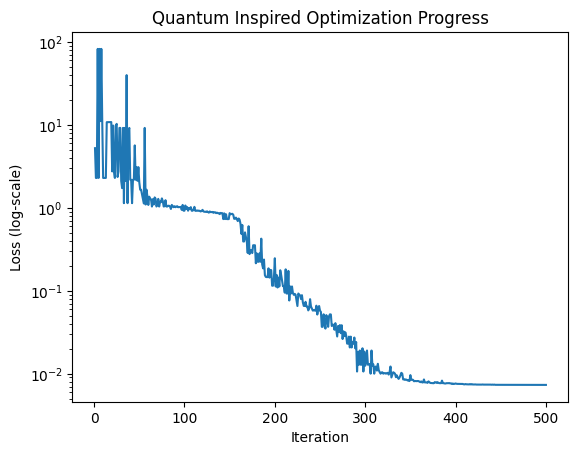

In [127]:
xdata = np.loadtxt('xdata.txt')
ydata = np.loadtxt('data150_6.txt')

de = QuantumInspiredDE(xdata, ydata)
de.optimize()

import matplotlib.pyplot as plt
plt.semilogy(range(1, len(de.loss_list)+1), de.loss_list)
plt.xlabel('Iteration')
plt.ylabel('Loss (log-scale)')
plt.title('Quantum Inspired Optimization Progress')
plt.show()


In [128]:
de.best_pop

array([0.09263583, 0.18913224, 1.75712778, 1.82585119, 2.59106011])

In [129]:
# Inspried DE  [0.09266477 0.18910248 1.75727822 1.82425376 2.59106498] 0.0073221572179695



In [130]:
import csv

n_runs = 12
# Create a list to store the results
results = []
method = 'QI_DE'
xdata = np.loadtxt('xdata.txt')
ydata = np.loadtxt('ydata_noisy5dB.txt')
# xdata = np.loadtxt('xdata.txt')
# ydata = np.loadtxt('data150_6.txt')

for i in range(n_runs):
#     # Mask 20% of the data
#     n_mask = int(len(ydata) * 0.2)
#     mask_indices = np.random.choice(len(ydata), size=n_mask, replace=False)
#     ydata_masked = ydata.copy()
#     ydata_masked[mask_indices] = np.nan
    
#     mask = np.logical_not(np.isnan(ydata_masked))
#     # Apply the mask to the data
#     xdata = xdata[mask]
#     ydata = ydata[mask]
    
    # Fit the model to the data using the least squares method
    #result = model.fit(ydata, params, x=xdata, method=method)
    de = QuantumInspiredDE(xdata, ydata)
    de.optimize()
    
    # Record the results
    results.append({
        'run': i + 1,
        'method': method,
        'b': de.best_pop[1],
        'omega': de.best_pop[2],
        'residual': de.loss_list[-1]
    })

# Write the results to a CSV file
with open('./data/results_{0}_mask20.csv'.format(method), 'w', newline='') as csvfile:
    fieldnames = ['run', 'method', 'b', 'omega', 'residual']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for result in results:
        writer.writerow(result)

# Print the fit results for the last run
print("Results using least sq:")
# print(fit_report(result))

Quantum-inspired DE result: [0.09126108 0.18463803 1.76401859 1.86968091 2.59164282] 29.92589843469367
Quantum-inspired DE result: [0.09078561 0.18682245 1.76249663 1.86492314 2.59186658] 29.925262854841886
Quantum-inspired DE result: [0.09069622 0.18656606 1.76259437 1.86466358 2.59187056] 29.925263779319668
Quantum-inspired DE result: [0.09075232 0.1868034  1.76255633 1.86472264 2.59185928] 29.925263150271082
Quantum-inspired DE result: [0.09079618 0.18686295 1.76245204 1.86516825 2.59186504] 29.925262884961487
Quantum-inspired DE result: [0.09074811 0.18655758 1.76271611 1.86477754 2.59187195] 29.92526448612594
Quantum-inspired DE result: [0.09060499 0.18725574 1.7634751  1.86237365 2.591849  ] 29.92528576853797
Quantum-inspired DE result: [0.09079073 0.18683378 1.76252002 1.86489421 2.59186471] 29.925262827115684
Quantum-inspired DE result: [0.09079023 0.18686361 1.76251573 1.86482618 2.59186249] 29.925262881616987
Quantum-inspired DE result: [0.09187855 0.1890639  1.76284356 1.867

PermissionError: [Errno 13] Permission denied: './data/results_QI_DE_mask20.csv'